In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from scipy import integrate, optimize
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Embedding, Reshape, Flatten, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, BatchNormalization

# --- setup ---
pd.set_option('max_columns', 50)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
config = tf.ConfigProto()

config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/opt/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/opt/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/opt/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Pa

In [2]:
all_df = pd.read_csv("data/owid-covid-data.csv",  keep_default_na=False)
population_ = pd.read_csv('data/population_by_country_2020.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (4,5,10,11,44,45,46,47,48,49,51,52,56,57,58) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
population_.loc[population_['Country (or dependency)'] == 'United States', 'Country (or dependency)'] = "US"
population_.loc[population_['Country (or dependency)'] == 'South Korea', 'Country (or dependency)'] = "Korea, South"
population_.loc[population_['Country (or dependency)'] == 'Sao Tome & Principe', 'Country (or dependency)'] = "Sao Tome and Principe"
population_.loc[population_['Country (or dependency)'] == 'Taiwan', 'Country (or dependency)'] = "Taiwan*"

population_.loc[population_['Country (or dependency)'] == 'Myanmar', 'Country (or dependency)'] = "Burma"
population_.loc[population_['Country (or dependency)'] == 'Congo', 'Country (or dependency)'] = "Congo (Brazzaville)"
population_.loc[population_['Country (or dependency)'] == 'DR Congo', 'Country (or dependency)'] = "Congo (Kinshasa)"
population_.loc[population_['Country (or dependency)'] == "Côte d'Ivoire", 'Country (or dependency)'] = "Cote d'Ivoire"

population_.loc[population_['Country (or dependency)'] == 'Czech Republic (Czechia)', 'Country (or dependency)'] = "Czechia"
population_.loc[population_['Country (or dependency)'] == 'Saint Kitts & Nevis', 'Country (or dependency)'] = "Saint Kitts and Nevis"
population_.loc[population_['Country (or dependency)'] == 'St. Vincent & Grenadines', 'Country (or dependency)'] = "Saint Vincent and the Grenadines"


population_.rename({'Population (2020)': 'population', 'Country (or dependency)': 'country', 'Yearly Change': 'yearly_change', 
                 'Net Change': 'net_change', 'Density (P/Km²)': 'density', 'Land Area (Km²)': 'land_area', 
                 'Migrants (net)': 'migrants', 'Fert. Rate': 'rert_rate', 'Med. Age': 'med_age', 
                 'Urban Pop %': 'urban_pop', 'World Share': 'world_share'}, axis=1, inplace=True)
population_["yearly_change"] = population_["yearly_change"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")
population_["urban_pop"] = population_["urban_pop"].apply(lambda x: x.replace(" ", "").replace("N.A.","0").replace("%","")).astype("float")
population_["world_share"] = population_["world_share"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")

population_["rert_rate"] = population_["rert_rate"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")
population_["med_age"] = population_["med_age"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")

population_.rert_rate.fillna(0, inplace=True)
population_.migrants.fillna(0, inplace=True)

population_["net_change"] = population_["net_change"].astype("float")
population_["density"] = population_["density"].astype("float")
population_["land_area"] = population_["land_area"].astype("float")
population_["population"] = population_["population"].astype("float")

population_["r_population"] = population_["population"]

population_["population"] = population_["population"] / max(population_["population"])
population_["yearly_change"] = population_["yearly_change"] / max(population_["yearly_change"])
population_["urban_pop"] = population_["urban_pop"] / max(population_["urban_pop"])
population_["world_share"] = population_["world_share"] / max(population_["world_share"])
population_["net_change"] = population_["net_change"] / max(population_["net_change"])
population_["density"] = population_["density"] / max(population_["density"])
population_["land_area"] = population_["land_area"] / max(population_["land_area"])
population_["rert_rate"] = population_["rert_rate"] / max(population_["rert_rate"])
population_["med_age"] = population_["med_age"] / max(population_["med_age"])
population_["migrants"] = population_["migrants"] / max(population_["migrants"])

In [60]:
def deal_country_data(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    df = pd.DataFrame()
    df["country"] = data_df["location"]
    df["date"] = data_df["date"]
    df["confirmed"] = data_df["new_cases"]
    df["fatalities"] = data_df["new_deaths"]
    # df["population"] = train_df["population"]
    df["population_density"] = data_df["population_density"]
    df["median_age"] = data_df["median_age"]
    df["aged_65_older"] = data_df["aged_65_older"]
    df["aged_70_older"] = data_df["aged_70_older"]
     
    country_df = df.merge(population_, how="left", on=['country']).drop_duplicates()
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    country_df["population_density"] = pd.to_numeric(country_df["population_density"])
    country_df["median_age"] = pd.to_numeric(country_df["median_age"])
    country_df["aged_65_older"] = pd.to_numeric(country_df["aged_65_older"])
    country_df["aged_70_older"] = pd.to_numeric(country_df["aged_70_older"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    return  country_df

def deal_global_df(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    country_df = pd.DataFrame()
    country_df["country"] = data_df["location"]
    country_df["date"] = data_df["date"]
    country_df["confirmed"] = data_df["new_cases"]
    country_df["fatalities"] = data_df["new_deaths"]
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    list_cur = []
    list_cur.append({"country":nname,
                "population":population_["population"].mean(),
                "yearly_change":population_["yearly_change"].mean(),
                "net_change":population_["net_change"].mean(),
                "density":population_["density"].mean(),
                "land_area":population_["land_area"].mean(),
                "migrants":population_["migrants"].mean(),
                "rert_rate":population_["rert_rate"].mean(),
                "med_age":population_["med_age"].mean(),
                "urban_pop":population_["urban_pop"].mean(),
                "world_share":population_["world_share"].mean()})
    df = pd.DataFrame(list_cur)
    
    data_df = country_df.merge(df, how="left", on=['country']).drop_duplicates()
    
    
    return data_df

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def plot_data(t):

    plt.plot(range(0, t.shape[0]), t["confirmed"])
    plt.plot(range(0, t.shape[0]), t["fatalities"])
    plt.title('Confirmed & Fatalities Data')
    plt.ylabel('confirmed & Fatalities')
    plt.xlabel('Epoch')
    plt.show()
    

In [61]:
global_df = deal_global_df(population_, all_df, "World", "global")         ####
us_df     = deal_country_data(population_, all_df, "United States", "US")  ####
italy_df  = deal_country_data(population_, all_df, "Italy", "Italy")    ####
france_df = deal_country_data(population_, all_df, "France", "France")  ####
japan_df  = deal_country_data(population_, all_df, "Japan", "Japan")    ####

china_df   = deal_country_data(population_, all_df, "China", "China")
spain_df   = deal_country_data(population_, all_df, "Spain", "Spain")
uk_df      = deal_country_data(population_, all_df, "United Kingdom", "United Kingdom")
germany_df = deal_country_data(population_, all_df, "Germany", "Germany")

koread_df = deal_country_data(population_, all_df, "South Korea", "South Korea")

In [69]:
canada_df = deal_country_data(population_, all_df, "Canada", "Canada")
india_df = deal_country_data(population_, all_df, "India", "India")
russia_df = deal_country_data(population_, all_df, "Russia", "Russia")

In [63]:
def addCsvDelNa(df): #累加
    temp_df = df.copy()
    temp_df = temp_df.dropna(axis=0,how='any')
    confirmed_ = temp_df.confirmed.fillna(0).astype(np.float32)
    fatalities_ = temp_df.fatalities.fillna(0).astype(np.float32)
    confirmed_ = np.array(confirmed_).reshape(-1, 1)
    fatalities_ = np.array(fatalities_).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

def addCsvRepNa(df): #累加
    temp_df = df.copy()
    confirmed_ = temp_df.confirmed.fillna(0).astype(np.float32)
    fatalities_ = temp_df.fatalities.fillna(0).astype(np.float32)
    confirmed_ = np.array(confirmed_).reshape(-1, 1)
    fatalities_ = np.array(fatalities_).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

In [64]:
global_df_ = addCsvDelNa(global_df)
us_df_     = addCsvDelNa(us_df)

# italy_df_  = addCsvDelNa(italy_df)
# france_df_ = addCsvDelNa(france_df)
# japan_df_  = addCsvDelNa(japan_df)

italy_df_  = addCsvRepNa(italy_df)
france_df_ = addCsvRepNa(france_df)
japan_df_  = addCsvRepNa(japan_df)

china_df_   = addCsvRepNa(china_df)
spain_df_   = addCsvRepNa(spain_df)
uk_df_      = addCsvDelNa(uk_df)
germany_df_ = addCsvDelNa(germany_df)


koread_df_ = addCsvRepNa(koread_df)

# china_df_   = addCsvDelNa(china_df)
# spain_df_   = addCsvDelNa(spain_df)
# uk_df_      = addCsvDelNa(uk_df)
# germany_df_ = addCsvDelNa(germany_df)

In [71]:
canada_df_ = addCsvDelNa(canada_df)
india_df_  = addCsvDelNa(india_df)
russia_df_ = addCsvDelNa(russia_df)

### SIR

In [13]:
from sklearn.preprocessing import StandardScaler

def test(name):
    total = 0
    if name == 'global':
        list1 = np.array(population_['r_population']).tolist()
        for ele in range(0, len(list1)):
            total = total + list1[ele]
    else:
        total = population_[population_['country'] == name]['r_population'].values[0]
    return total

def SIR(country_df, population, names):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    
    confirmed_  = country_df.confirmed.fillna(0)
    fatalities_ = country_df.fatalities.fillna(0)
    
    confirmed_ = np.array(confirmed_)
    fatalities_ = np.array(fatalities_)

    scaler1.fit(confirmed_.reshape(-1, 1))
    confirmed_ = scaler1.transform(confirmed_.reshape(-1, 1)).reshape(-1)
    
    scaler2.fit(fatalities_.reshape(-1, 1))
    fatalities_ = scaler2.transform(fatalities_.reshape(-1, 1)).reshape(-1)

    sir_df = pd.DataFrame()
    sir_df['confirmed'] = confirmed_ #country_df.confirmed.fillna(0)
    sir_df['fatalities'] = fatalities_ #country_df.fatalities.fillna(0)
    sir_df = sir_df[sir_df['confirmed'] >= 0]
    sir_df['day_count'] = list(range(1,len(sir_df)+1))
    
    ydata = [i for i in sir_df.confirmed]
    xdata = sir_df.day_count
    rdata = [i for i in sir_df.fatalities]
    
    rdata = np.array(rdata, dtype=float)
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)
    
#     N = population[population['country'] == names]['r_population'].values[0]
    N = test(names)
    print(N)
    inf0 = ydata[0]
    rec0 = 0
    sus0 = N - inf0 - rec0
    
    def sir_model(y, x, beta, gamma):
        sus = -beta * y[0] * y[1] / N
        rec = gamma * y[1]
        inf = -(sus + rec)
        return sus, inf, rec
    
    def fit_odeint_c(x, beta, gamma):
        return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]
    
    def fit_odeint_r(x, beta, gamma):
        return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,2]
    
    popt, pcov = optimize.curve_fit(fit_odeint_c, xdata, ydata)
    fitted_c = fit_odeint_c(xdata, *popt)
    
    popt, pcov = optimize.curve_fit(fit_odeint_r, xdata, rdata)
    fitted_r = fit_odeint_r(xdata, *popt)
    
    
    fig = plt.figure(figsize=[20, 5])
    plt.subplot(121)
    plt.plot(xdata, ydata, 'o')
    plt.plot(xdata, fitted_c)
    plt.title("Fit of SIR model for " + names + " infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.legend(['groundtruth', 'predictions'], loc='best')
    
    plt.subplot(122)
    plt.plot(xdata, rdata, 'o')
    plt.plot(xdata, fitted_r)
    plt.title("Fit of SIR model for " + names + " infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.legend(['groundtruth', 'predictions'], loc='best')
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    
    return fitted_c, fitted_r


In [14]:
def deal_SIR(df,name, population=population_):
    fc, fr = SIR(df, population, name)
    
    sirData = pd.DataFrame()
    sirData["confirmed"]  = fc
    sirData["fatalities"] = fr
    sirData["date"] = df["date"]
    idex = list(range(0, sirData.shape[0]))
    sirData["day"] = idex

#     sirData = log2_(sirData)
    plot_data(sirData)
    return sirData

60479424.0


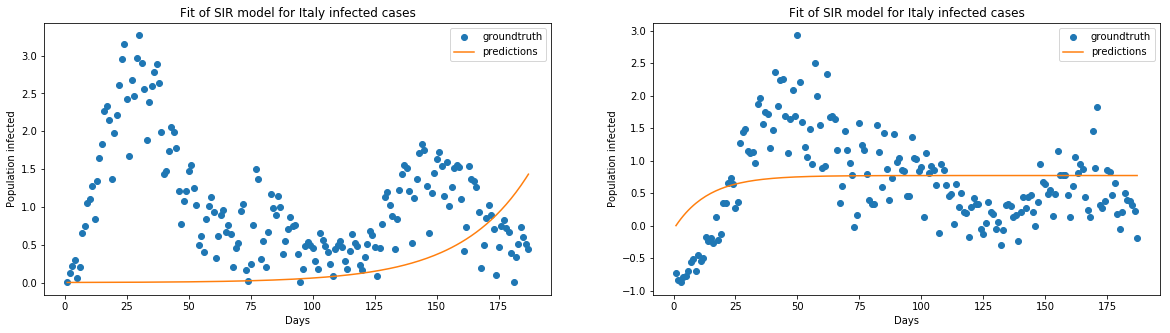

Optimal parameters: beta = 34.939461618258676  and gamma =  35.013087685589575


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



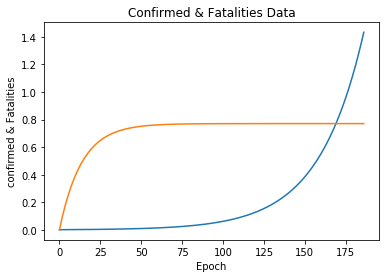

,confirmed,fatalities,date,day
0,0.001620,0.000000,2020-01-31,0
1,0.001680,0.054687,2020-02-01,1
2,0.001743,0.105493,2020-02-02,2
3,0.001807,0.152692,2020-02-03,3
4,0.001875,0.196541,2020-02-04,4
...,...,...,...,...
182,1.237834,0.770447,2020-07-31,182
183,1.283818,0.770447,2020-08-01,183
184,1.331510,0.770447,2020-08-02,184
185,1.380974,0.770447,2020-08-03,185


In [11]:
deal_SIR(italy_df, "Italy", population_)

330610570.0


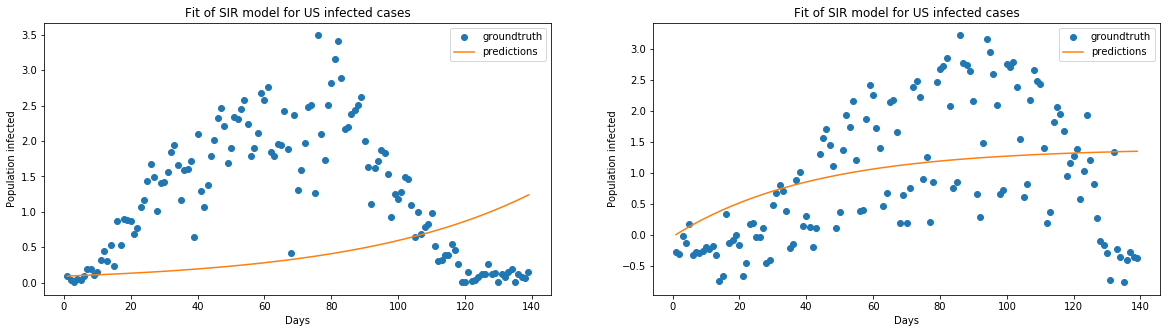

Optimal parameters: beta = 0.3404925835648174  and gamma =  0.36458074136426294


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



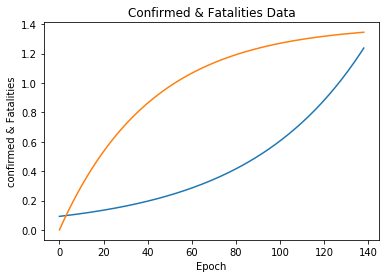

,confirmed,fatalities,date,day
0,0.092235,0.000000,2020-01-22,0
1,0.093987,0.033225,2020-01-23,1
2,0.095773,0.065660,2020-01-24,2
3,0.097592,0.097322,2020-01-25,3
4,0.099446,0.128232,2020-01-26,4
...,...,...,...,...
134,1.148317,1.340658,2020-06-04,134
135,1.170131,1.341976,2020-06-05,135
136,1.192360,1.343261,2020-06-06,136
137,1.215011,1.344517,2020-06-07,137


In [12]:
deal_SIR(us_df, "US", population_)

7777967034.0


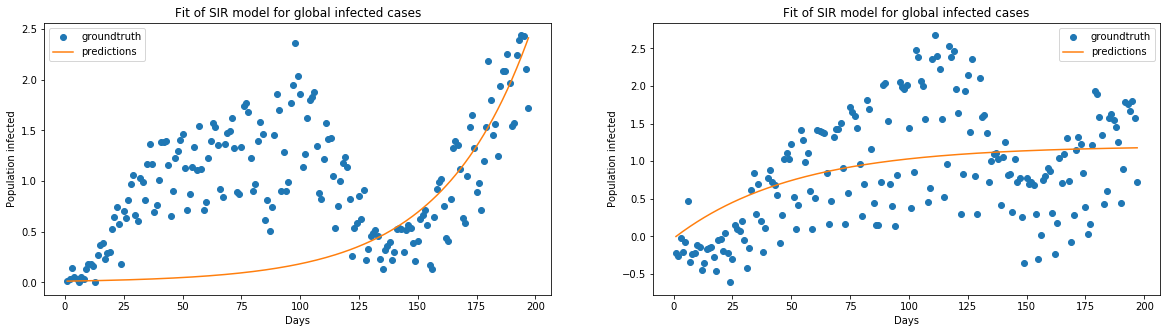

Optimal parameters: beta = 1.7548068641452654  and gamma =  1.7744434189177496


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



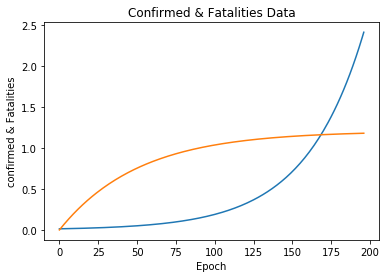

,confirmed,fatalities,date,day
0,0.013333,0.000000,2020-01-22,0
1,0.013692,0.023428,2020-01-23,1
2,0.014060,0.046401,2020-01-24,2
3,0.014437,0.068927,2020-01-25,3
4,0.014825,0.091016,2020-01-26,4
...,...,...,...,...
192,2.168269,1.177087,2020-08-01,192
193,2.226536,1.177627,2020-08-02,193
194,2.286368,1.178157,2020-08-03,194
195,2.347809,1.178676,2020-08-04,195


In [13]:
deal_SIR(global_df, "global", population_)

### GAN

In [15]:
def StandData(df):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    
#     confirmed_  = df.confirmed.fillna(0)
#     fatalities_ = df.fatalities.fillna(0)
    
    confirmed_ = np.array(df.confirmed)
    fatalities_ = np.array(df.fatalities)

    scaler1.fit(confirmed_.reshape(-1, 1))
    confirmed_ = scaler1.transform(confirmed_.reshape(-1, 1)).reshape(-1)
    
    scaler2.fit(fatalities_.reshape(-1, 1))
    fatalities_ = scaler2.transform(fatalities_.reshape(-1, 1)).reshape(-1)
    
    df["confirmed"] = confirmed_
    df["fatalities"] = fatalities_
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

In [16]:
class Gan(object):
    def __init__(self, sequence_length, g_len, country="US", length = 15):
        self.sequence_length = sequence_length
        self.g_len = g_len
        self.length = length
        self.country = country
        
        self.noiseSet = False #设定是 使用SIR作为噪音数据 还是  使用随机噪声
           
    def dealNoist(self, df):
        
        begin_prediction = df[df['day'] == (df.iloc[-1, -1] - self.length + 1)]['day'].values[0]
        
        rows = df[df['day'] < begin_prediction]
        confirmed_trend = [float(x) for x in rows.confirmed.values]
        mu = 0
        sigma = 0.12
        for i in range(rows.shape[0]):
            confirmed_trend.append(random.gauss(mu,sigma))
        self.noiseData = np.reshape(np.asarray(confirmed_trend), [rows.shape[0] * 2, 1])
        
#         self.noiseData = np.reshape(np.asarray(confirmed_trend), [rows.shape[0], 1])
        self.noiseSet = True #使用SIR作为噪音数据
        return self.noiseData
        
    def trainData(self, tamp_df, country, colName = "confirmed_trend"):
        self.country = country
        begin_prediction = tamp_df[tamp_df['day'] == (tamp_df.iloc[-1, -1] - self.length + 1)]['day'].values[0]
        rows = tamp_df[tamp_df['day'] < begin_prediction]
        trend_list = []
        for i in range(0, len(rows)):
            if i + self.sequence_length < len(rows):
                confirmed_trend = [float(x) for x in rows[i:i+self.sequence_length].confirmed.values]
                fatality_trend = [float(x) for x in rows[i:i+self.sequence_length].fatalities.values]

                trend_list.append({"confirmed_trend":confirmed_trend,
                                "fatality_trend":fatality_trend})

        trend_df = pd.DataFrame(trend_list)
        trend_df["temporal_inputs"] = [np.asarray([trends[colName]]) 
                                       for idx,trends in trend_df.iterrows()]
        trend_df = shuffle(trend_df)
        data = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in trend_df["temporal_inputs"].values]),
                                                              (trend_df.shape[0],1,self.sequence_length)),(0,2,1) )).astype(np.float32)
        return data
    
    def discriminator(self, input_layer, reuse=False, trainable=True):
         with tf.variable_scope("discriminator", reuse=reuse):
        
            conv = tf.layers.conv2d(input_layer, 64, [1, 1], padding='SAME')
#             conv = tf.layers.batch_normalization(conv, trainable=trainable)
            conv = tf.nn.relu(conv)
            
            conv = tf.layers.conv2d(conv, 128, [1, 1], padding='SAME')
#             conv = tf.layers.batch_normalization(conv, trainable=trainable)
            conv = tf.nn.relu(conv)
            
            conv = tf.layers.conv2d(conv, 256, [2, 1], padding='SAME')
#             conv = tf.layers.batch_normalization(conv, trainable=trainable)
            conv = tf.nn.relu(conv)
            
            conv = tf.layers.conv2d(conv, 512, [2, 1], padding='SAME')
#             conv = tf.layers.batch_normalization(conv, trainable=trainable)
            conv = tf.nn.relu(conv)
            
            flat = tf.layers.flatten(conv)
            dense = tf.layers.dense(flat, 1)
            
        
            return dense
    
    def generator(self, input_layer, reuse=False, trainable=True):
        with tf.variable_scope("generator", reuse=reuse):
            
            dense = tf.layers.dense(input_layer, self.sequence_length * 1024 * 1)
            
            flat  = tf.reshape(dense, [-1, self.sequence_length, 1, 1024])
#             flat = tf.layers.batch_normalization(flat, trainable=trainable)
            flat = tf.nn.relu(flat)
            
            tconv = tf.layers.conv2d_transpose(flat, 512, kernel_size=[1, 1], strides=[1, 1], padding='SAME')
#             tconv = tf.layers.batch_normalization(tconv, trainable=trainable)
            tconv = tf.nn.relu(tconv)
            
            tconv = tf.layers.conv2d_transpose(tconv, 256, kernel_size=[1, 1], strides=[1, 1], padding='SAME')
#             tconv = tf.layers.batch_normalization(tconv, trainable=trainable)
            tconv = tf.nn.relu(tconv)
            
            tconv = tf.layers.conv2d_transpose(tconv, 128, kernel_size=[1, 1], strides=[1, 1], padding='SAME')
#             tconv = tf.layers.batch_normalization(tconv, trainable=trainable)
            tconv = tf.nn.relu(tconv)
    
            tconv = tf.layers.conv2d_transpose(tconv, 1, kernel_size=[1, 1], strides=[1, 1], padding='SAME')
#             tconv = tf.layers.batch_normalization(tconv, trainable=trainable)
            tconv = tf.nn.relu(tconv, name="gen_data")
    
        return tconv
    
    def plot_loss(self):
        fig = plt.figure(figsize=[20, 5])

        plt.subplot(121)
        plt.plot(self.all_ds)
        plt.title('Loss over epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['d_loss'], loc='best')

        plt.subplot(122)
        plt.plot(self.all_gs)
        plt.title('Loss over epochs for the number of cases')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['g_loss', 'Validation'], loc='best')

        plt.show()
        
    def train(self, data, iter_epoch=2000, learning_rate=0.00002, beta1=0.5):
        tf.reset_default_graph()

        x = tf.placeholder(tf.float32, shape=[None, self.sequence_length, 1, 1], name="Data")
        noise = tf.placeholder(tf.float32, shape=[None, self.g_len], name="Noise")
        
        G = self.generator(noise, reuse=False)
        print(G.shape)
        D_real = self.discriminator(x, reuse=False)
        D_fake = self.discriminator(G, reuse=True)

        D_real_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
        D_fake_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
        D_loss = D_real_loss + D_fake_loss

        G_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            g_op = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta1=beta1).minimize(G_loss, var_list=g_vars)
            d_op = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta1=beta1).minimize(D_loss, var_list=d_vars)
        print("network build success")
        
        self.all_ds = []
        self.all_gs = []
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(iter_epoch):
                total_batch = int(data.shape[0])
                
                nsl = self.random_noise(total_batch)
                ds, _ = sess.run([D_loss, d_op], feed_dict={x: data, noise: nsl})
                
                for j in range(3):
                    ns2 = np.random.uniform(low=-1, high=1, size=[total_batch, self.g_len])
                    gs, _ = sess.run([G_loss, g_op], feed_dict={x: data, noise: ns2})
                
                self.all_ds.append(ds)
                self.all_gs.append(gs)
                print("Iter: {}      d_loss: {:.4}       g_loss: {:.4}".format(i, ds, gs))
                
            saver.save(sess, "./gan_model/" + self.country + "_model")
            
    def random_noise(self, num):
        if self.noiseSet == True:
            bk  = [random.randint(0,self.noiseData.shape[0] - 1) for _ in range(num * self.g_len)]
            ns1 = np.reshape(self.noiseData[bk, :], [num, self.g_len])
        else:
            ns1 = np.random.uniform(low=-1, high=1, size=[num, self.g_len])
        return ns1
            
    def predict(self, num):
        
        ns1 = self.random_noise(num)
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, "./gan_model/" + self.country + "_model")

            graph = tf.get_default_graph()
            noise = graph.get_tensor_by_name("Noise:0")
            data_ = graph.get_tensor_by_name("generator/gen_data:0")
            feed_dict ={noise : ns1}
            data = sess.run(data_,feed_dict)
        return np.reshape(data, [data.shape[0], data.shape[1], data.shape[2]])


In [17]:
def ganData(seq, lens, df, name, noiseSet = True, colName = "confirmed_trend"):
    temp_data = df.copy()
    temp_data = temp_data.iloc[:-30]
    print(temp_data.shape)
    gan = Gan(seq, lens)
    temp_data = StandData(temp_data)
#     temp_data = log2_(df)
    
    data = gan.trainData(temp_data, name, colName)
    data = np.reshape(data[:, :, :], [data.shape[0], data.shape[1], data.shape[2], 1])
    
    if noiseSet == True:
        sirData = deal_SIR(temp_data.copy(), name)
        noise = gan.dealNoist(sirData)
    
    gan.train(data)
    gan.plot_loss()
    return gan

In [50]:
koread_df_

,country,date,confirmed,fatalities,population_density,median_age,aged_65_older,aged_70_older,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share,r_population


(421, 19)
145922010.0


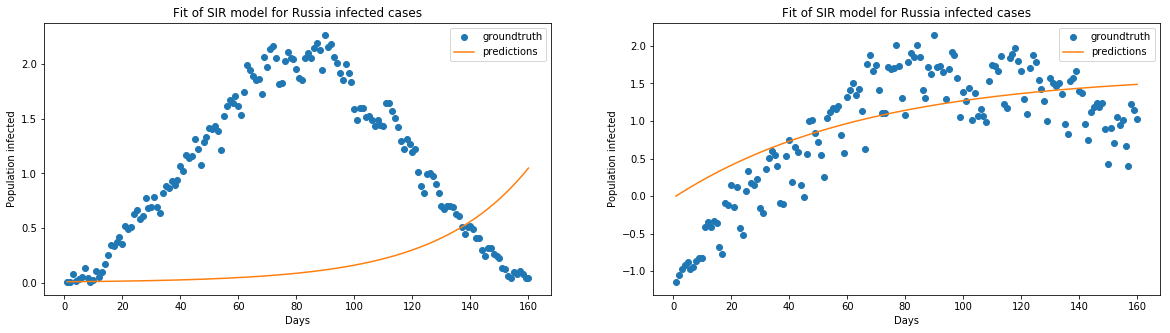

Optimal parameters: beta = 3.4887260892630763  and gamma =  3.50393090239063


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



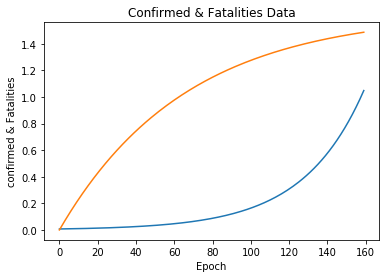

(?, 61, 1, 1)
network build success
Iter: 0      d_loss: 1.386       g_loss: 0.6932
Iter: 1      d_loss: 1.386       g_loss: 0.6932
Iter: 2      d_loss: 1.386       g_loss: 0.6932
Iter: 3      d_loss: 1.386       g_loss: 0.6932
Iter: 4      d_loss: 1.386       g_loss: 0.6932
Iter: 5      d_loss: 1.386       g_loss: 0.6931
Iter: 6      d_loss: 1.386       g_loss: 0.6931
Iter: 7      d_loss: 1.386       g_loss: 0.6931
Iter: 8      d_loss: 1.386       g_loss: 0.6931
Iter: 9      d_loss: 1.386       g_loss: 0.6931
Iter: 10      d_loss: 1.386       g_loss: 0.6931
Iter: 11      d_loss: 1.386       g_loss: 0.6931
Iter: 12      d_loss: 1.386       g_loss: 0.6931
Iter: 13      d_loss: 1.386       g_loss: 0.6931
Iter: 14      d_loss: 1.386       g_loss: 0.6931
Iter: 15      d_loss: 1.386       g_loss: 0.6931
Iter: 16      d_loss: 1.386       g_loss: 0.6931
Iter: 17      d_loss: 1.386       g_loss: 0.6931
Iter: 18      d_loss: 1.386       g_loss: 0.6931
Iter: 19      d_loss: 1.386       g_loss: 0

Iter: 166      d_loss: 1.386       g_loss: 0.6931
Iter: 167      d_loss: 1.386       g_loss: 0.6931
Iter: 168      d_loss: 1.386       g_loss: 0.6931
Iter: 169      d_loss: 1.386       g_loss: 0.6931
Iter: 170      d_loss: 1.386       g_loss: 0.6931
Iter: 171      d_loss: 1.386       g_loss: 0.6931
Iter: 172      d_loss: 1.386       g_loss: 0.6931
Iter: 173      d_loss: 1.386       g_loss: 0.6931
Iter: 174      d_loss: 1.386       g_loss: 0.6931
Iter: 175      d_loss: 1.386       g_loss: 0.6931
Iter: 176      d_loss: 1.386       g_loss: 0.6931
Iter: 177      d_loss: 1.386       g_loss: 0.6931
Iter: 178      d_loss: 1.386       g_loss: 0.6931
Iter: 179      d_loss: 1.386       g_loss: 0.6931
Iter: 180      d_loss: 1.386       g_loss: 0.6931
Iter: 181      d_loss: 1.386       g_loss: 0.6931
Iter: 182      d_loss: 1.386       g_loss: 0.6931
Iter: 183      d_loss: 1.386       g_loss: 0.6931
Iter: 184      d_loss: 1.386       g_loss: 0.6931
Iter: 185      d_loss: 1.386       g_loss: 0.6931


Iter: 330      d_loss: 1.386       g_loss: 0.6931
Iter: 331      d_loss: 1.386       g_loss: 0.6931
Iter: 332      d_loss: 1.386       g_loss: 0.6931
Iter: 333      d_loss: 1.386       g_loss: 0.6931
Iter: 334      d_loss: 1.386       g_loss: 0.6931
Iter: 335      d_loss: 1.386       g_loss: 0.6931
Iter: 336      d_loss: 1.386       g_loss: 0.6931
Iter: 337      d_loss: 1.386       g_loss: 0.6931
Iter: 338      d_loss: 1.386       g_loss: 0.6931
Iter: 339      d_loss: 1.386       g_loss: 0.6931
Iter: 340      d_loss: 1.386       g_loss: 0.6931
Iter: 341      d_loss: 1.386       g_loss: 0.6931
Iter: 342      d_loss: 1.386       g_loss: 0.6931
Iter: 343      d_loss: 1.386       g_loss: 0.6931
Iter: 344      d_loss: 1.386       g_loss: 0.6931
Iter: 345      d_loss: 1.386       g_loss: 0.6931
Iter: 346      d_loss: 1.386       g_loss: 0.6931
Iter: 347      d_loss: 1.386       g_loss: 0.6931
Iter: 348      d_loss: 1.386       g_loss: 0.6931
Iter: 349      d_loss: 1.386       g_loss: 0.6931


Iter: 494      d_loss: 1.386       g_loss: 0.6931
Iter: 495      d_loss: 1.386       g_loss: 0.6931
Iter: 496      d_loss: 1.386       g_loss: 0.6931
Iter: 497      d_loss: 1.386       g_loss: 0.6931
Iter: 498      d_loss: 1.386       g_loss: 0.6931
Iter: 499      d_loss: 1.386       g_loss: 0.6931
Iter: 500      d_loss: 1.386       g_loss: 0.6931
Iter: 501      d_loss: 1.386       g_loss: 0.6931
Iter: 502      d_loss: 1.386       g_loss: 0.6931
Iter: 503      d_loss: 1.386       g_loss: 0.6931
Iter: 504      d_loss: 1.386       g_loss: 0.6931
Iter: 505      d_loss: 1.386       g_loss: 0.6931
Iter: 506      d_loss: 1.386       g_loss: 0.6931
Iter: 507      d_loss: 1.386       g_loss: 0.6931
Iter: 508      d_loss: 1.386       g_loss: 0.6931
Iter: 509      d_loss: 1.386       g_loss: 0.6931
Iter: 510      d_loss: 1.386       g_loss: 0.6931
Iter: 511      d_loss: 1.386       g_loss: 0.6931
Iter: 512      d_loss: 1.386       g_loss: 0.6931
Iter: 513      d_loss: 1.386       g_loss: 0.6931


Iter: 658      d_loss: 1.386       g_loss: 0.6931
Iter: 659      d_loss: 1.386       g_loss: 0.6931
Iter: 660      d_loss: 1.386       g_loss: 0.6931
Iter: 661      d_loss: 1.386       g_loss: 0.6931
Iter: 662      d_loss: 1.386       g_loss: 0.6931
Iter: 663      d_loss: 1.386       g_loss: 0.6931
Iter: 664      d_loss: 1.386       g_loss: 0.6931
Iter: 665      d_loss: 1.386       g_loss: 0.6931
Iter: 666      d_loss: 1.386       g_loss: 0.6931
Iter: 667      d_loss: 1.386       g_loss: 0.6931
Iter: 668      d_loss: 1.386       g_loss: 0.6931
Iter: 669      d_loss: 1.386       g_loss: 0.6931
Iter: 670      d_loss: 1.386       g_loss: 0.6931
Iter: 671      d_loss: 1.386       g_loss: 0.6931
Iter: 672      d_loss: 1.386       g_loss: 0.6931
Iter: 673      d_loss: 1.386       g_loss: 0.6931
Iter: 674      d_loss: 1.386       g_loss: 0.6931
Iter: 675      d_loss: 1.386       g_loss: 0.6931
Iter: 676      d_loss: 1.386       g_loss: 0.6931
Iter: 677      d_loss: 1.386       g_loss: 0.6931


Iter: 823      d_loss: 1.386       g_loss: 0.6931
Iter: 824      d_loss: 1.386       g_loss: 0.6931
Iter: 825      d_loss: 1.386       g_loss: 0.6931
Iter: 826      d_loss: 1.386       g_loss: 0.6931
Iter: 827      d_loss: 1.386       g_loss: 0.6931
Iter: 828      d_loss: 1.386       g_loss: 0.6931
Iter: 829      d_loss: 1.386       g_loss: 0.6931
Iter: 830      d_loss: 1.386       g_loss: 0.6931
Iter: 831      d_loss: 1.386       g_loss: 0.6931
Iter: 832      d_loss: 1.386       g_loss: 0.6931
Iter: 833      d_loss: 1.386       g_loss: 0.6931
Iter: 834      d_loss: 1.386       g_loss: 0.6931
Iter: 835      d_loss: 1.386       g_loss: 0.6931
Iter: 836      d_loss: 1.386       g_loss: 0.6931
Iter: 837      d_loss: 1.386       g_loss: 0.6931
Iter: 838      d_loss: 1.386       g_loss: 0.6931
Iter: 839      d_loss: 1.386       g_loss: 0.6931
Iter: 840      d_loss: 1.386       g_loss: 0.6931
Iter: 841      d_loss: 1.386       g_loss: 0.6931
Iter: 842      d_loss: 1.386       g_loss: 0.6931


Iter: 987      d_loss: 1.386       g_loss: 0.6931
Iter: 988      d_loss: 1.386       g_loss: 0.6931
Iter: 989      d_loss: 1.386       g_loss: 0.6931
Iter: 990      d_loss: 1.386       g_loss: 0.6931
Iter: 991      d_loss: 1.386       g_loss: 0.6931
Iter: 992      d_loss: 1.386       g_loss: 0.6931
Iter: 993      d_loss: 1.386       g_loss: 0.6931
Iter: 994      d_loss: 1.386       g_loss: 0.6931
Iter: 995      d_loss: 1.386       g_loss: 0.6931
Iter: 996      d_loss: 1.386       g_loss: 0.6931
Iter: 997      d_loss: 1.386       g_loss: 0.6931
Iter: 998      d_loss: 1.386       g_loss: 0.6931
Iter: 999      d_loss: 1.386       g_loss: 0.6931
Iter: 1000      d_loss: 1.386       g_loss: 0.6931
Iter: 1001      d_loss: 1.386       g_loss: 0.6931
Iter: 1002      d_loss: 1.386       g_loss: 0.6931
Iter: 1003      d_loss: 1.386       g_loss: 0.6931
Iter: 1004      d_loss: 1.386       g_loss: 0.6931
Iter: 1005      d_loss: 1.386       g_loss: 0.6931
Iter: 1006      d_loss: 1.386       g_loss: 

Iter: 1149      d_loss: 1.386       g_loss: 0.6931
Iter: 1150      d_loss: 1.386       g_loss: 0.6931
Iter: 1151      d_loss: 1.386       g_loss: 0.6931
Iter: 1152      d_loss: 1.386       g_loss: 0.6931
Iter: 1153      d_loss: 1.386       g_loss: 0.6931
Iter: 1154      d_loss: 1.386       g_loss: 0.6931
Iter: 1155      d_loss: 1.386       g_loss: 0.6931
Iter: 1156      d_loss: 1.386       g_loss: 0.6931
Iter: 1157      d_loss: 1.386       g_loss: 0.6931
Iter: 1158      d_loss: 1.386       g_loss: 0.6931
Iter: 1159      d_loss: 1.386       g_loss: 0.6931
Iter: 1160      d_loss: 1.386       g_loss: 0.6931
Iter: 1161      d_loss: 1.386       g_loss: 0.6931
Iter: 1162      d_loss: 1.386       g_loss: 0.6931
Iter: 1163      d_loss: 1.386       g_loss: 0.6931
Iter: 1164      d_loss: 1.386       g_loss: 0.6931
Iter: 1165      d_loss: 1.386       g_loss: 0.6931
Iter: 1166      d_loss: 1.386       g_loss: 0.6931
Iter: 1167      d_loss: 1.386       g_loss: 0.6931
Iter: 1168      d_loss: 1.386  

Iter: 1311      d_loss: 1.386       g_loss: 0.6931
Iter: 1312      d_loss: 1.386       g_loss: 0.6931
Iter: 1313      d_loss: 1.386       g_loss: 0.6931
Iter: 1314      d_loss: 1.386       g_loss: 0.6931
Iter: 1315      d_loss: 1.386       g_loss: 0.6931
Iter: 1316      d_loss: 1.386       g_loss: 0.6931
Iter: 1317      d_loss: 1.386       g_loss: 0.6931
Iter: 1318      d_loss: 1.386       g_loss: 0.6931
Iter: 1319      d_loss: 1.386       g_loss: 0.6931
Iter: 1320      d_loss: 1.386       g_loss: 0.6931
Iter: 1321      d_loss: 1.386       g_loss: 0.6931
Iter: 1322      d_loss: 1.386       g_loss: 0.6931
Iter: 1323      d_loss: 1.386       g_loss: 0.6931
Iter: 1324      d_loss: 1.386       g_loss: 0.6931
Iter: 1325      d_loss: 1.386       g_loss: 0.6931
Iter: 1326      d_loss: 1.386       g_loss: 0.6931
Iter: 1327      d_loss: 1.386       g_loss: 0.6931
Iter: 1328      d_loss: 1.386       g_loss: 0.6931
Iter: 1329      d_loss: 1.386       g_loss: 0.6931
Iter: 1330      d_loss: 1.386  

Iter: 1473      d_loss: 1.386       g_loss: 0.6931
Iter: 1474      d_loss: 1.386       g_loss: 0.6931
Iter: 1475      d_loss: 1.386       g_loss: 0.6931
Iter: 1476      d_loss: 1.386       g_loss: 0.6931
Iter: 1477      d_loss: 1.386       g_loss: 0.6931
Iter: 1478      d_loss: 1.386       g_loss: 0.6931
Iter: 1479      d_loss: 1.386       g_loss: 0.6931
Iter: 1480      d_loss: 1.386       g_loss: 0.6931
Iter: 1481      d_loss: 1.386       g_loss: 0.6931
Iter: 1482      d_loss: 1.386       g_loss: 0.6931
Iter: 1483      d_loss: 1.386       g_loss: 0.6931
Iter: 1484      d_loss: 1.386       g_loss: 0.6931
Iter: 1485      d_loss: 1.386       g_loss: 0.6931
Iter: 1486      d_loss: 1.386       g_loss: 0.6931
Iter: 1487      d_loss: 1.386       g_loss: 0.6931
Iter: 1488      d_loss: 1.386       g_loss: 0.6931
Iter: 1489      d_loss: 1.386       g_loss: 0.6931
Iter: 1490      d_loss: 1.386       g_loss: 0.6931
Iter: 1491      d_loss: 1.386       g_loss: 0.6931
Iter: 1492      d_loss: 1.386  

Iter: 1634      d_loss: 1.386       g_loss: 0.6931
Iter: 1635      d_loss: 1.386       g_loss: 0.6931
Iter: 1636      d_loss: 1.386       g_loss: 0.6931
Iter: 1637      d_loss: 1.386       g_loss: 0.6931
Iter: 1638      d_loss: 1.386       g_loss: 0.6931
Iter: 1639      d_loss: 1.386       g_loss: 0.6931
Iter: 1640      d_loss: 1.386       g_loss: 0.6931
Iter: 1641      d_loss: 1.386       g_loss: 0.6931
Iter: 1642      d_loss: 1.386       g_loss: 0.6931
Iter: 1643      d_loss: 1.386       g_loss: 0.6931
Iter: 1644      d_loss: 1.386       g_loss: 0.6931
Iter: 1645      d_loss: 1.386       g_loss: 0.6931
Iter: 1646      d_loss: 1.386       g_loss: 0.6931
Iter: 1647      d_loss: 1.386       g_loss: 0.6931
Iter: 1648      d_loss: 1.386       g_loss: 0.6931
Iter: 1649      d_loss: 1.386       g_loss: 0.6931
Iter: 1650      d_loss: 1.386       g_loss: 0.6931
Iter: 1651      d_loss: 1.386       g_loss: 0.6931
Iter: 1652      d_loss: 1.386       g_loss: 0.6931
Iter: 1653      d_loss: 1.386  

Iter: 1795      d_loss: 1.386       g_loss: 0.6931
Iter: 1796      d_loss: 1.386       g_loss: 0.6931
Iter: 1797      d_loss: 1.386       g_loss: 0.6931
Iter: 1798      d_loss: 1.386       g_loss: 0.6931
Iter: 1799      d_loss: 1.386       g_loss: 0.6931
Iter: 1800      d_loss: 1.386       g_loss: 0.6931
Iter: 1801      d_loss: 1.386       g_loss: 0.6931
Iter: 1802      d_loss: 1.386       g_loss: 0.6931
Iter: 1803      d_loss: 1.386       g_loss: 0.6931
Iter: 1804      d_loss: 1.386       g_loss: 0.6931
Iter: 1805      d_loss: 1.386       g_loss: 0.6931
Iter: 1806      d_loss: 1.386       g_loss: 0.6931
Iter: 1807      d_loss: 1.386       g_loss: 0.6931
Iter: 1808      d_loss: 1.386       g_loss: 0.6931
Iter: 1809      d_loss: 1.386       g_loss: 0.6931
Iter: 1810      d_loss: 1.386       g_loss: 0.6931
Iter: 1811      d_loss: 1.386       g_loss: 0.6931
Iter: 1812      d_loss: 1.386       g_loss: 0.6931
Iter: 1813      d_loss: 1.386       g_loss: 0.6931
Iter: 1814      d_loss: 1.386  

Iter: 1957      d_loss: 1.386       g_loss: 0.6931
Iter: 1958      d_loss: 1.386       g_loss: 0.6931
Iter: 1959      d_loss: 1.386       g_loss: 0.6931
Iter: 1960      d_loss: 1.386       g_loss: 0.6931
Iter: 1961      d_loss: 1.386       g_loss: 0.6931
Iter: 1962      d_loss: 1.386       g_loss: 0.6931
Iter: 1963      d_loss: 1.386       g_loss: 0.6931
Iter: 1964      d_loss: 1.386       g_loss: 0.6931
Iter: 1965      d_loss: 1.386       g_loss: 0.6931
Iter: 1966      d_loss: 1.386       g_loss: 0.6931
Iter: 1967      d_loss: 1.386       g_loss: 0.6931
Iter: 1968      d_loss: 1.386       g_loss: 0.6931
Iter: 1969      d_loss: 1.386       g_loss: 0.6931
Iter: 1970      d_loss: 1.386       g_loss: 0.6931
Iter: 1971      d_loss: 1.386       g_loss: 0.6931
Iter: 1972      d_loss: 1.386       g_loss: 0.6931
Iter: 1973      d_loss: 1.386       g_loss: 0.6931
Iter: 1974      d_loss: 1.386       g_loss: 0.6931
Iter: 1975      d_loss: 1.386       g_loss: 0.6931
Iter: 1976      d_loss: 1.386  

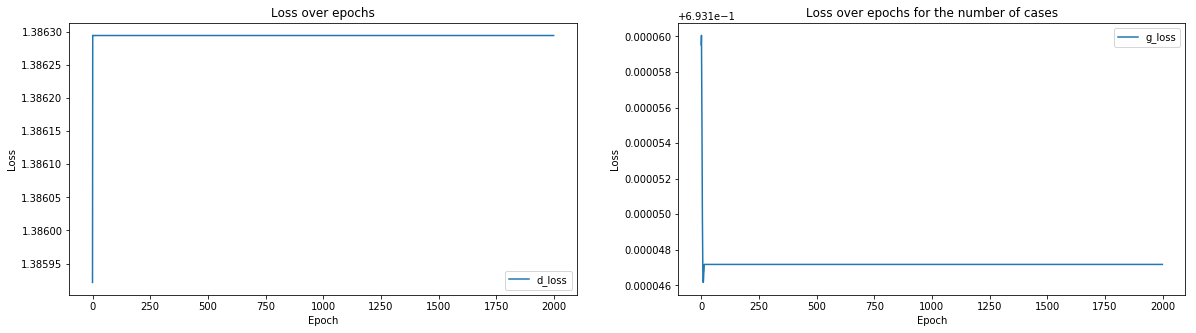

In [88]:
## noiseSet = True  数据AN
## noiseSet = False 随机噪声数据
gan = ganData(61, 60, russia_df.copy(), "Russia", noiseSet = True, colName = "fatality_trend") #confirmed_trend   fatality_trend

In [984]:
global_df = deal_global_df(population_, all_df, "World", "global")         ####
us_df     = deal_country_data(population_, all_df, "United States", "US")  ####
italy_df  = deal_country_data(population_, all_df, "Italy", "Italy")    ####
france_df = deal_country_data(population_, all_df, "France", "France")  ####
japan_df  = deal_country_data(population_, all_df, "Japan", "Japan")    ####

china_df   = deal_country_data(population_, all_df, "China", "China")
spain_df   = deal_country_data(population_, all_df, "Spain", "Spain")
uk_df      = deal_country_data(population_, all_df, "United Kingdom", "United Kingdom")
germany_df = deal_country_data(population_, all_df, "Germany", "Germany")
koread_df = deal_country_data(population_, all_df, "South Korea", "South Korea")

canada_df = deal_country_data(population_, all_df, "Canada", "Canada")
india_df = deal_country_data(population_, all_df, "India", "India")
russia_df = deal_country_data(population_, all_df, "Russia", "Russia")

global_df_ = addCsvDelNa(global_df)
us_df_     = addCsvDelNa(us_df)

italy_df_  = addCsvDelNa(italy_df)
# france_df_ = addCsvDelNa(france_df)
# japan_df_  = addCsvDelNa(japan_df)

# italy_df_  = addCsvRepNa(italy_df)
france_df_ = addCsvRepNa(france_df)
japan_df_  = addCsvRepNa(japan_df)

# china_df_   = addCsvRepNa(china_df)
# spain_df_   = addCsvRepNa(spain_df)
# uk_df_      = addCsvRepNa(uk_df)
# germany_df_ = addCsvRepNa(germany_df)

china_df_   = addCsvDelNa(china_df)
spain_df_   = addCsvDelNa(spain_df)
uk_df_      = addCsvDelNa(uk_df)
germany_df_ = addCsvDelNa(germany_df)



In [87]:
np.save('./ganDataNew/stand_russia_del30_confirmed_noise_1000',gdata )  #confirmed  fatality

In [ ]:
# stand_global_+_del80_confirmed_noise_61_1000  SIR作为噪音数据 生成数据
# stand_global_+_del80_confirmed_SJ_noise_61_1000  随机噪声作为噪音数据 生成数据
